<a href="https://colab.research.google.com/github/andrew-veriga/sunpower/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html

<!-- from astropy.coordinates import get_sun -->

##Получение данных из excel

In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

###Создание датасета

In [0]:
df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_9_Astrakhan_-_gotovo.xlsx", parse_dates=["Дата","Время"],infer_datetime_format=True, index_col=None)

# df['Location'] = 'Черный Яр'
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_5_Dosang_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата")
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_6_Kharabali_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата"))
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_7_Zelenga_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата"))
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_9_Astrakhan_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата"))

df['Время']= pd.to_timedelta(df['Время'].dt.hour, unit='h')
df['Дата'] = pd.to_datetime(df['Дата'].dt.date) + df['Время']# pd.to_timedelta(df['Время'].dt.hour, unit='h')


In [3]:
df=df.set_index('Дата').drop(columns=['№ п/п','Время'])
df.head()

,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Общая облачность,"Текущая погода, сообщаемая с метеорологической станции",Прошедшая погода между сроками наблюдения 1,Прошедшая погода между сроками наблюдения 2,"Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые облака","Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдащихся облаков Cm",Высота основания самых низких облаков (м),"Высококучевые, высокослоистые и слоисто-дождевые облака","Перистые, перисто-кучевые и перисто-слоистые облака",Горизонтальная дальность видимости (км)
Дата,,,,,,,,,,,,,,,,,
2019-01-01 01:00:00,0.000000,0.7,772.4,770.4,84,67.5,2,100%.,Снег неливневый.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,Слоистые разорванные или кучевые разорванные о...,70 – 80%.,300-600,Высокослоистые непросвечивающие или слоисто-до...,NaN,10
2019-01-01 04:00:00,0.000000,-0.2,772.5,770.5,90,67.5,1,100%.,Снег непрерывный умеренный в срок наблюдения.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,Слоистые разорванные или кучевые разорванные о...,70 – 80%.,300-600,Высокослоистые непросвечивающие или слоисто-до...,NaN,2
2019-01-01 07:00:00,0.000000,-0.8,772.4,770.4,90,67.5,2,100%.,Снег непрерывный слабый в срок наблюдения.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,Слоистые разорванные или кучевые разорванные о...,70 – 80%.,300-600,Высокослоистые непросвечивающие или слоисто-до...,NaN,4
2019-01-01 10:00:00,0.050111,-1.2,773.0,771.0,89,90.0,3,100%.,Дымка.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,"Слоисто-кучевые, образовавшиеся не из кучевых.",100%.,600-1000,NaN,NaN,4
2019-01-01 13:00:00,1.187667,-0.5,772.1,770.1,87,67.5,2,100%.,Дымка.,Облака покрывали более половины неба в течение...,Облака покрывали более половины неба в течение...,"Слоисто-кучевых, слоистых, кучевых или кучево-...",100%.,"2500 или более, или облаков нет.",Высокослоистые просвечивающие.,NaN,4


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


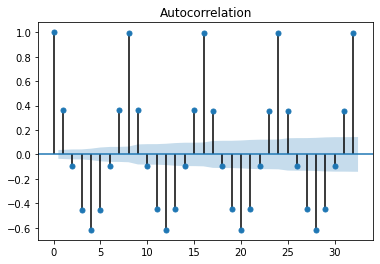

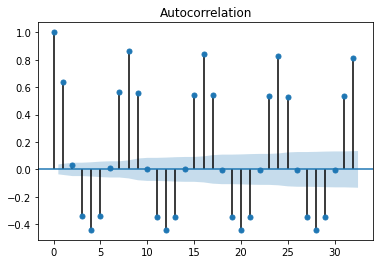

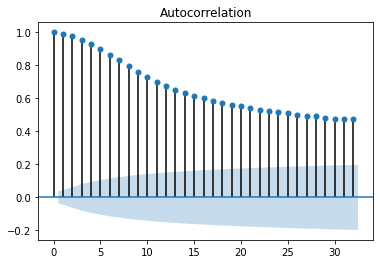

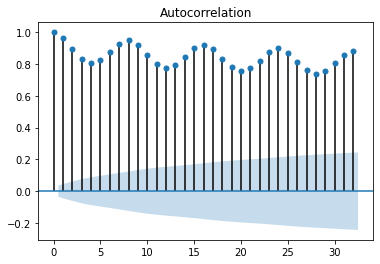

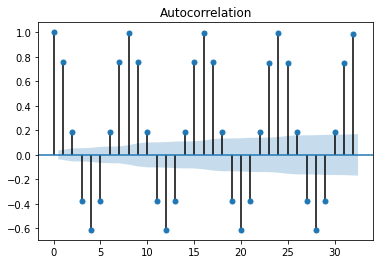

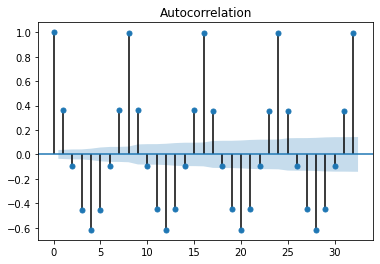

In [4]:
import astropy.units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
numeric_columns=[
            'Мощность, МВт',
            'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
            'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
            # 'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
            'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
            #'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
            'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
            ]
#df['Время']=[pd.Timedelta(t,'h') for t in df['Время'].dt.hour]

series = df[numeric_columns].fillna(value=0)

# autocorrelation_plot(series)
# pyplot.show()            
# Черный яр : 48.060120° с.ш. 46.108620° в.д.
# Географические координаты Черного Яра. Широта : 48°03′44″ с.ш. Долгота: 46°06′32″ в.д. Высота над уровнем моря: 1 м.
# Астрахань 46.361433 48.060790
location = EarthLocation(lon=46.361433, lat= 48.060790, height=-20)
datetimes= Time(df.index)+4*u.hour
frame = AltAz(obstime=datetimes, location=location)
sun_altaz=get_sun(datetimes).transform_to(frame)

series['Sun_alt']= sun_altaz.alt
series['Sun_az'] = sun_altaz.az

lags = 32
size=(25, 9)
# pyplot.figure(figsize=(25, 9))
plot_acf(series['Мощность, МВт'], lags=lags)
plot_acf( series['Атмосферное давление на уровне станции (миллиметры ртутного столба)'], lags=lags)
plot_acf( series['Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли'], lags=lags)
plot_acf( series['Sun_alt'], lags=lags)
plot_acf( series['Sun_az'], lags=lags)
# pyplot.show()


In [0]:
   
# добавление one-hot векторов значений для колонок 'Общая облачность' и "Высота облаков"

clouds= df['Общая облачность'].astype('category')
clouds_height=df['Высота основания самых низких облаков (м)'].astype('category')
weather = df['Текущая погода, сообщаемая с метеорологической станции '].fillna(method= 'ffill').astype('category')
wing_direction = df['Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения '].fillna(value='No').astype('category')

# weather_1 = df['Прошедшая погода между сроками наблюдения 1'].fillna(method= 'ffill').astype('category')
# weather_2 = df['Прошедшая погода между сроками наблюдения 2'].fillna(method= 'ffill').astype('category')

series=pd.concat([
                  series,
                  pd.get_dummies(clouds, prefix='Облака',dummy_na=True).fillna(value=0),
                  pd.get_dummies(clouds_height,prefix='Высота',dummy_na=True).fillna(value=0),
                  pd.get_dummies(weather,prefix='Погода'),
                  pd.get_dummies(wing_direction, prefix='НаправлениеВетра'),
                  # pd.get_dummies(weather_2,prefix='Погода2'),
                  # pd.get_dummies(weather_1,prefix='Погода1')
                  ],axis=1)              


#series.drop(columns=['Время'])
# # Добавление колонок "Время дня" и "Месяц года"
# series.insert(0,'Месяц', series.index.month)
# series.insert(1,'Время', series.index.hour)# series['Время'].map(lambda x: np.int(x.strftime('%H')))#.astype(np.string_)#.map(lambda x: x.strftime('%H'))

# нормализация данных
from sklearn.preprocessing import MinMaxScaler

norm_cols = numeric_columns
# norm_cols.remove('Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ')
series[norm_cols] = series[norm_cols].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
series[norm_cols] = scaler.fit_transform(series[norm_cols])

# norm_cols.remove('Мощность, МВт')

# data_mean= series.loc[:, norm_cols].mean(axis=0)
# data_std = series.loc[:, norm_cols].std(axis=0)
# series.loc[:, norm_cols] = (series.loc[:, norm_cols]-data_mean)/data_std
#автокорелляция данных
# series=series.corr()
###################




In [7]:
norm_cols

['Мощность, МВт',
 'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
 'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
 'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
 'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ']

проба из https://www.tensorflow.org/tutorials/structured_data/time_series

In [0]:
### проба из https://www.tensorflow.org/tutorials/structured_data/time_series
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)
######################################
# past_history = window_size
# future_target = 1
# STEP = 1
# ds= series.values
# target = series['Мощность, МВт'].values
# x_train_single, y_train_single = multivariate_data(ds, target, 0,
#                                                    split_datetime, past_history,
#                                                    future_target, STEP,
#                                                    single_step=True)

###Оформление оконного датасета

In [0]:
def windowed_dataset(series, target, window_size, batch_size, shuffle_buffer):
  target_col=series.columns.get_loc(target)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1,target_col]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
def make_splitdataset(df, split_pos, window_size, batch_size, shuffle_buffer_size):
  x_train = series[:split_pos]
  x_valid = series[split_pos:]

  ds_train = windowed_dataset(x_train, 'Мощность, МВт', window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
  ds_val = windowed_dataset(x_valid, 'Мощность, МВт', window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
  return ds_train, ds_val


##Сборка и тренировка модели

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-6 * 10**(epoch / 20))
tf.random.set_seed(51)
np.random.seed(51)

def make_model(train_shape):
  m = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=128, kernel_size=2,
                      strides=1, padding= "causal",
                      activation="relu",
                      input_shape=[None, train_shape]),
      tf.keras.layers.MaxPooling1D(pool_size=2),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1)
    ])

  
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
  m.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
  return m
  
def train_model(model, train, validation, epoch_num=50):
  history = model.fit(train, validation_data=(validation), epochs=epoch_num)#,callbacks=[lr_schedule])
  return history

In [0]:
tf.keras.backend.clear_session()
window_size = int(24/3*2)
batch_size = 120
shuffle_buffer_size = 1000
split_datetime = 2500

train, validation = make_splitdataset(series, split_datetime ,window_size, batch_size, shuffle_buffer_size)
Model = make_model(series.shape[1])

In [84]:
history = train_model(Model, train, validation,600)#600

Epoch 1/600
21/21 [==============================] - 1s 64ms/step - loss: 0.2503 - mae: 0.3957 - val_loss: 0.0284 - val_mae: 0.1358
Epoch 2/600
21/21 [==============================] - 0s 22ms/step - loss: 0.1427 - mae: 0.3013 - val_loss: 0.0180 - val_mae: 0.0930
Epoch 3/600
21/21 [==============================] - 0s 23ms/step - loss: 0.0982 - mae: 0.2493 - val_loss: 0.0170 - val_mae: 0.0822
Epoch 4/600
21/21 [==============================] - 0s 23ms/step - loss: 0.0742 - mae: 0.2169 - val_loss: 0.0179 - val_mae: 0.0861
Epoch 5/600
21/21 [==============================] - 0s 21ms/step - loss: 0.0611 - mae: 0.1941 - val_loss: 0.0157 - val_mae: 0.0815
Epoch 6/600
21/21 [==============================] - 1s 25ms/step - loss: 0.0450 - mae: 0.1651 - val_loss: 0.0152 - val_mae: 0.0838
Epoch 7/600
21/21 [==============================] - 1s 25ms/step - loss: 0.0394 - mae: 0.1525 - val_loss: 0.0177 - val_mae: 0.0834
Epoch 8/600
21/21 [==============================] - 0s 22ms/step - loss: 0.

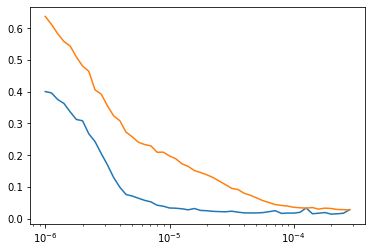

In [67]:

 
lrs = 1e-6 * (10 ** (np.arange(50) / 20))
plt.semilogx(lrs, history.history["val_loss"][:])
plt.semilogx(lrs, history.history["loss"][:])
# plt.axis([1e-6, 200, 0, 20])

###Анализ функции потерь

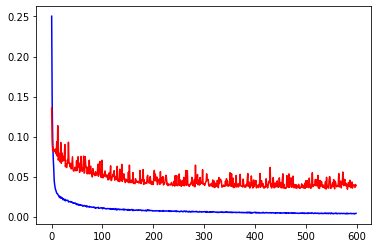

In [85]:
loss = history.history['loss']
mae = history.history['val_mae']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, mae, 'r', label='Training mae')

plt.show()

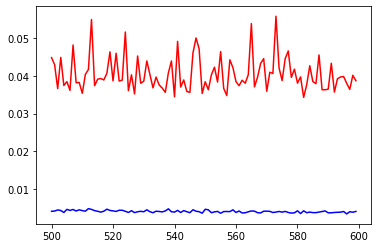

In [86]:
# Plot all but the first 10
loss = history.history['loss']
mae = history.history['val_mae']

epochs = range(len(loss)-100, len(loss))
plot_loss = loss[-100:]
plot_mae = mae[-100:]

plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.plot(epochs, plot_mae, 'r', label='Training Loss')

plt.show()

<Figure size 432x288 with 0 Axes>

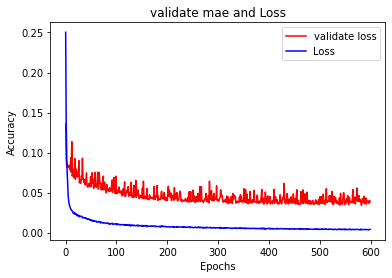

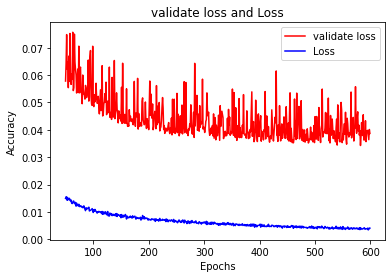

<Figure size 432x288 with 0 Axes>

In [87]:
val_mae=history.history['val_mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot validate loss and Loss
#------------------------------------------------
plt.plot(epochs, val_mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('validate mae and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["validate loss", "Loss"])

plt.figure()

epochs_zoom = epochs[50:]
mae_zoom = val_mae[50:]
loss_zoom = loss[50:]

#------------------------------------------------
# Plot Zoomed validate loss and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('validate loss and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["validate loss", "Loss"])

plt.figure()

### График сравнения предсказанной мощности с реальной, взятой из таблицы

In [0]:
# def windowed_dataset(series, target, window_size, batch_size, shuffle_buffer):
#   target_col=series.columns.get_loc(target)
#   dataset = tf.data.Dataset.from_tensor_slices(series)
#   dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#   dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#   dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1,target_col]))
#   dataset = dataset.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast.flatten()

In [88]:
from sklearn.metrics import mean_squared_error

forecast=model_forecast(Model, series[split_datetime-window_size:], window_size)
# invert scaling for forecast
test = pd.DataFrame(series[split_datetime:])
actuals = scaler.inverse_transform(test.loc[:, norm_cols].values)[:,0]
test['Мощность, МВт'] = forecast[:-1]
results = scaler.inverse_transform(test.loc[:, norm_cols].values)[:,0]
# calculate RMSE
rmse = mean_squared_error(actuals, results)
print('Test RMSE: %.3f' % rmse)
# invert scaling for actual
# test.loc[:, cols]=scaler.inverse_transform(test.loc[:, cols])
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

# results = forecast
# results = np.squeeze(forecast)#[:, 0, 0]




Test RMSE: 0.877


In [0]:
def plot_series(time, series, format="-", start=0, end=None, legend=None):
    plt.plot(time[start:end], series[start:end], format )
    plt.xlabel("Time")
    plt.ylabel("Value")
    # plt.legend(legend)
    plt.grid(True)

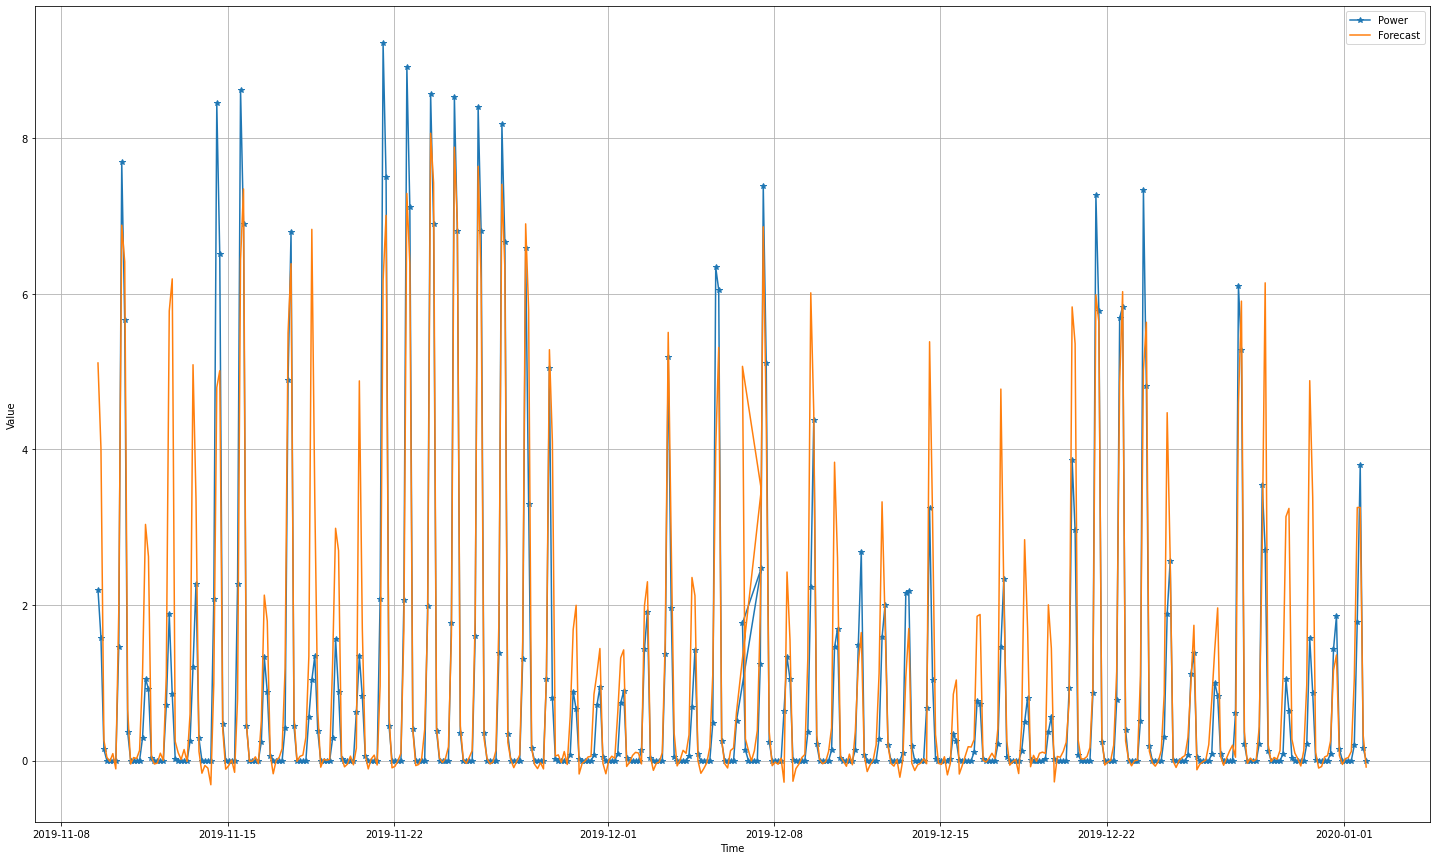

In [89]:
#import matplotlib.pyplot as plt

time_train = test.index#.to_numpy(dtype=np.datetime64)
plt.figure(figsize=(25, 15))
# plt.ylim(top=2)
plot_series(time_train, actuals, format='-*')#,start=200)#,end=200)
plot_series(time_train, results)#,start=200)#,end=200)
plt.legend(['Power', 'Forecast'])